In [1]:
#Setting up notebook
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [2]:
#Import useful libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import os

#Import UFSS
import ufss

In [3]:
# these are helper functions defined in ufss for convenient forward and backward dft
# they use pyfftw
ift = ufss.signals.SignalProcessing.ift1D
ft = ufss.signals.SignalProcessing.ft1D

In [4]:
folder = 'circular_test'
os.makedirs(folder,exist_ok=True)

## Constructing the Liouvillian

Begin by making the Hamiltonian, identical to closed case

In [5]:
# since this system consists of 3 energy levels, we construct three occupation operators:
# Ground state:
n0 = np.zeros((3,3))
n0[0,0] = 1
# first excited state:
n1 = np.zeros((3,3))
n1[1,1] = 1
#second excited state:
n2 = np.zeros((3,3))
n2[2,2] = 1

# the Hamiltonian is given as
epsilon = 1 # energy gap between ground and lowest excited state (rotated away)
depsilon = 0.1 # energy gap between lowest excited state and next excited state
H = 0*n0 + epsilon * n1 + (epsilon + depsilon) * n2
II = np.eye(H.shape[0]) #Identity of same dimension as H
print(H)

[[0.  0.  0. ]
 [0.  1.  0. ]
 [0.  0.  1.1]]


In [6]:
# eigenvalues are the diagonal entries of H
eigenvalues = H.diagonal()

# matrix of eigenvectors is simply the identity
eigenvectors = np.eye(eigenvalues.size)

In order to describe the light-matter interaction, we need to write down the dipole operator.  In order to enforce circular polarization selection rules, we describe the dipole transitions using cartesian coordinates:

In [7]:
# right and left-circularly polarized light are described as
r = np.array([1,-1j,0])/np.sqrt(2)
l = np.conjugate(r)

# we want r to excite from 0 -> 1:
mu_01 = np.array([1,1j,0])/np.sqrt(2)

# we want l to excite from 0 -> 2:
mu_02 = np.array([1,-1j,0])/np.sqrt(2)

mu = np.zeros((3,3,3),dtype='complex')
mu[1,0,:] = mu_01
mu[2,0,:] = mu_02

# Now in principle we should do the following to force mu to be Hermitian
mu_H = mu + np.conjugate(np.transpose(mu,axes=(1,0,2)))
# However, in UFSS, we usually enforce the rotating-wave approximation (RWA) by using what is defined here as
# "mu", and not "mu_H".  mu excites the ket wavefunction, and the complex conjugate transpose of mu de-excites
# the ket wavefunction.  Taking the conjugate transpose is handled automatically in UF2 (may not be implemented
# correctly in RKE yet)

In [8]:
# this is obviously cryptic, I'm sorry.  Everything in this cell is unnecessary, but allows ufss to run faster
# I need to work on cleaning up the directory structuring expected/created by various components of ufss!
os.makedirs(os.path.join(folder,'open','closed'),exist_ok=True)
np.savez(os.path.join(folder,'open','closed','mu.npz'),up=mu)

## Constructing the Liouvillian

We begin constructing the Liouvillian that describes the open quantum system by starting with the unitary evolution.  The Liouvillian (called L below), is a superoperator.  If the density matrix is a 3x3 matrix, UFSS works with it as a flattened 1D array (with 9 entries).  The Liouvillian is a superoperator that is a 9x9 non-hermitian matrix that includes the unitary evolution, as well as the relaxation and dephasing dynamics

In [9]:
I = np.eye(H.shape[0])
# the transpose comes from the way we have flattened the density matrix
L_closed = -1j*np.kron(H,I.T) + 1j*np.kron(I,H.T)

In [10]:
# this cell defines the temperature and rates for relaxation dynamics
kT = 0.1 # in units of omega_0, the mean optical gap between the ground and first excited state (above set to 1)

# for ease of use, none of the following should be set to precisely zero (but they can be set to be orders of 
# magnitude smaller than the rate of interest).  If you need to set them to precisely 0, you will need to
# manually specify the initial rho^(0) later (you should probably ask me how to do this!)
decay_rates = np.zeros(H.shape)
decay_rates[0,1] = 0.01 #decay rate of 1st excited state to ground state
decay_rates[0,2] = 0 #decay rate of 2nd excited state to ground state
decay_rates[1,2] = 0 #decay rate of 2nd excited state to 1st excited state

Note, as a check, I have set everything except the independent decay rates to very small numbers.  This means that for right- (left-) circularly polarized light, the homogeneous decay rate should be $T_2 = 2T_1$, so we should see a decay of the signal to $e^{-1}$ after $\tau+t=200\,(100)$ respectively.  This seems to be working.  Do you agree?

In [11]:
dephasing_21_rate = 0.0003 # pure dephasing between the two excited states
dephasing_eg_rate = 0.0004 # pure dephasing between the two excited states and the ground state

In [12]:
Lindblad_instructions = []
for i in range(H.shape[0]):
    for j in range(H.shape[0]):
        if i > j:
            decay_rate = decay_rates[j,i]
            decay_operator = np.zeros(H.shape)
            decay_operator[j,i] = 1
            ins = ufss.HLG.OpenPolymer.make_Lindblad_instructions(decay_rate,decay_operator)
            Lindblad_instructions += ins

            energy_difference = H[i,i] - H[j,j]
            if energy_difference == 0:
                excite_rate = decay_rate
            elif kT == 0:
                excite_rate = 0
            else:
                excite_rate = decay_rate * np.exp(-energy_difference/kT)
            excite_operator = decay_operator.T
            ins = ufss.HLG.OpenPolymer.make_Lindblad_instructions(excite_rate,excite_operator)
            Lindblad_instructions += ins

In [13]:
dephasing_21_operator = np.zeros(H.shape)
dephasing_21_operator[1,1] = -1
dephasing_21_operator[2,2] = 1

dephasing_eg_operator = np.zeros(H.shape)
dephasing_eg_operator[1,1] = 1
dephasing_eg_operator[2,2] = 1

ins = ufss.HLG.OpenPolymer.make_Lindblad_instructions(dephasing_eg_rate,dephasing_eg_operator)

Lindblad_instructions += ins

ins = ufss.HLG.OpenPolymer.make_Lindblad_instructions(dephasing_21_rate,dephasing_21_operator)

Lindblad_instructions += ins

In [14]:
D = ufss.HLG.OpenPolymer.make_Liouvillian(Lindblad_instructions)

In [15]:
L = L_closed + D
manL = ufss.HLG.ManualL(L,mu,savedir=os.path.join(folder,'open'),output='uf2')

## 2DPE

### Using UF$^2$ to calculate two-pulse photon echo

#### Start with impulsive limit

In [16]:
# Open systems works with DensityMatrices class
tpe = ufss.DensityMatrices(os.path.join(folder,'open/uf2'),detection_type='complex_polarization',conserve_memory=True)

What is detection_type?  There are 4 options, I'll describe two of them here:
1. detection_type = 'complex_polarization':

computes the complex quantity $P^{(n)}(t) = \langle \mu \rho^{(n)}(t)\rangle$, then performs the discrete Fourier transform (DFT) with respect to t, to get $\tilde{P}^{(n)}(\omega)$.  Next takes the input local oscillator electric field amplitude, $E_{LO}(t)$, and takes the DFT to get $\tilde{E}_{LO}(\omega)$, and finally compute the complex-valued frequency-resolved signal $S^{(n)}(\omega) = i E_{LO}(\omega)P^{(n)}(\omega)$

The advantage here is that you can get both the in-phase and out-of-phase components simultaneously

2. detection_type = 'polarization':

everything is the same as above, except that the final step is to compute the real-valued frequency-resolved signal $S^{(n)}(\omega) = \mathrm{Im}\left[E_{LO}(\omega)P^{(n)}(\omega)\right]$

The advantage here is that the output is more directly related to a single measurement.  You can control the phase of the local oscillator by using the method "set_local_oscillator_phase(phi)", where usually you might set phi = 0 or phi = np.pi/2

In [17]:
## Setup is the same

# defining the impulsive pulses in the RWA
c = 1 # center frequency ofthe laser pulse

pulse1 = np.array([1]) # pulse 1 amplitude is 1
t1 = np.array([0]) # impulsive limit, nonzero at a single time point

pulse2 = np.array([1]) # pulse 2 amplitude is 1
t2 = np.array([0]) # impulsive limit, nonzero at a single time point

lo = np.array([1]) # local oscillator amplitude is 1
lo_t = np.array([0]) # impulsive limit, nonzero at a single time point

pmc = [(0,1),(2,0)] #pmc stands for phase-matching condition. must include 1 tuple for each pulse
# excluding the local oscillator

tpe.set_efields([t1,t2,lo_t],[pulse1,pulse2,lo],[c,c,c],pmc)

pulse_polarizations = ['r','r','r']

tpe.set_polarization_sequence(pulse_polarizations)


#tpe.maximum_manifold = 1 # This is no longer meaningful, because we are allowing population to relax back to the
# ground state, and thus the concept of manifolds breaks down.  Note below there are now additional diagrams that
# look like excited-state absorption, which now must be calculated

/Users/prose/ufss/ufss/UF2/UF2_open_core.py:622: UserWarning: Could not automatically determine the initial thermal state. User must specify the initial condition, rho^(0), manually
  warnings.warn('Could not automatically determine the initial thermal state. User must specify the initial condition, rho^(0), manually')


ufss tries to automatically determine what the initial thermal state is, and uses that as the starting point for $\rho^{(0)}$.  However, this automated procedure only works if all of the populations are connected (at least indirectly) by relaxation rates.  If somee populations are not connected by relaxation rates, the automatic process fails, and the user must specify $\rho^{(0)}$.  The user can also over-ride the automatic $\rho^{(0)}$ if desired.

In [18]:
## uncomment if previous cell warns "Could not automatically determine the initial thermal state. User must specify the initial condition, rho^(0), manually"
## This cell creates a thermal distribution of populations to initialize
## rho0 can be anything you want it to be (must have the correct shape, in this case 3x3 matrix)
populations = np.exp(-eigenvalues/kT)
populations = populations/populations.sum()
rho0 = np.diag(populations)

tpe.set_rho0_manual(rho0)

In [19]:
# Now we need to define the time-mesh, t, that will be used to resolve the signal, P(t)
# This is done by specifying the optical dephasing rate, gamma, the time step, dt, and, optionally, gamma_res.
# The maximum time that will be resolved, t_max, is approximately gamma_res/gamma (rounded to a multiple of dt)
gamma = 0.2
dt = 1
tpe.gamma_res = 20 # default value for this is 6.91
tpe.set_t(gamma,dt=dt)
# This process sets the attribute "t":
print(tpe.t)

[-100  -99  -98  -97  -96  -95  -94  -93  -92  -91  -90  -89  -88  -87
  -86  -85  -84  -83  -82  -81  -80  -79  -78  -77  -76  -75  -74  -73
  -72  -71  -70  -69  -68  -67  -66  -65  -64  -63  -62  -61  -60  -59
  -58  -57  -56  -55  -54  -53  -52  -51  -50  -49  -48  -47  -46  -45
  -44  -43  -42  -41  -40  -39  -38  -37  -36  -35  -34  -33  -32  -31
  -30  -29  -28  -27  -26  -25  -24  -23  -22  -21  -20  -19  -18  -17
  -16  -15  -14  -13  -12  -11  -10   -9   -8   -7   -6   -5   -4   -3
   -2   -1    0    1    2    3    4    5    6    7    8    9   10   11
   12   13   14   15   16   17   18   19   20   21   22   23   24   25
   26   27   28   29   30   31   32   33   34   35   36   37   38   39
   40   41   42   43   44   45   46   47   48   49   50   51   52   53
   54   55   56   57   58   59   60   61   62   63   64   65   66   67
   68   69   70   71   72   73   74   75   76   77   78   79   80   81
   82   83   84   85   86   87   88   89   90   91   92   93   94   95
   96 

In [20]:
# Now we need to set the pulse delay
# I usually just take tau to be the non-negative values of t
# Note if you input negative values of tau, ufss will simulate the anti-ordered diagrams
tau = tpe.t.copy()[tpe.t > -15]
tpe.set_pulse_delays([tau])

Now let's check to make sure we gave UFSS the correct phase-matching condition by calling the diagrams that will be simulated

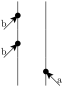

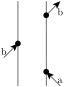

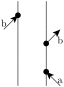

In [21]:
pulse_arrival_times = [0,1]
time_ordered_diagrams = tpe.get_diagrams(pulse_arrival_times)
tpe.display_diagrams(time_ordered_diagrams)
diagram_save_folder = os.path.join(folder,'diagrams')
os.makedirs(diagram_save_folder,exist_ok=True)
tpe.save_diagrams(time_ordered_diagrams,folder_name=diagram_save_folder)

NOTE: all of these 3 diagrams are unique, necessary calculations with density matrices, when the pulses are finite in length, and when relaxation processes connect the excited states to the ground state

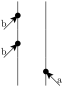

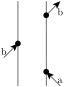

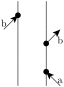

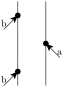

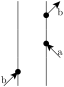

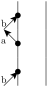

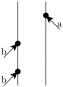

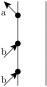

In [22]:
# Note that at tau = 0, all of the following diagrams will be simulated by default
pulse_arrival_times = [0,0]
all_diagrams = tpe.get_diagrams(pulse_arrival_times)
tpe.display_diagrams(all_diagrams)
tpe.save_diagrams(all_diagrams,folder_name=diagram_save_folder)

In [23]:
# To simulate the signal using all diagrams (ufss only simulates overlap diagrams when the pulses overlap)
full_signal = tpe.calculate_signal_all_delays()

# To force ufss to simulate only the time-ordered diagrams even when pulses overlap, use
time_ordered_signal = tpe.calculate_diagrams_all_delays(time_ordered_diagrams)

Note: the methods "calculate_signal_all_delays" and "calculate_diagrams_all_delays" automatically set the local oscillator arrival time to be coincident with the last pulse (in this case with the second pulse).  Let me know if you would like the flexibility to change this behavior.  I don't think it will be necessary, because taking the DFT of the output frequency resolved signal gives the convolution of the signal field with the local oscillator.

In [24]:
# signals are different at tau = 0:
print(np.allclose(full_signal[14,:],time_ordered_signal[14,:]))
# signals are the same for all other values of tau:
print(np.allclose(full_signal[15:,:],time_ordered_signal[15:,:]))

# Keep in mind that with finite pulses, the overlap diagrams contribute at more values of tau!

False
True


<IPython.core.display.Javascript object>


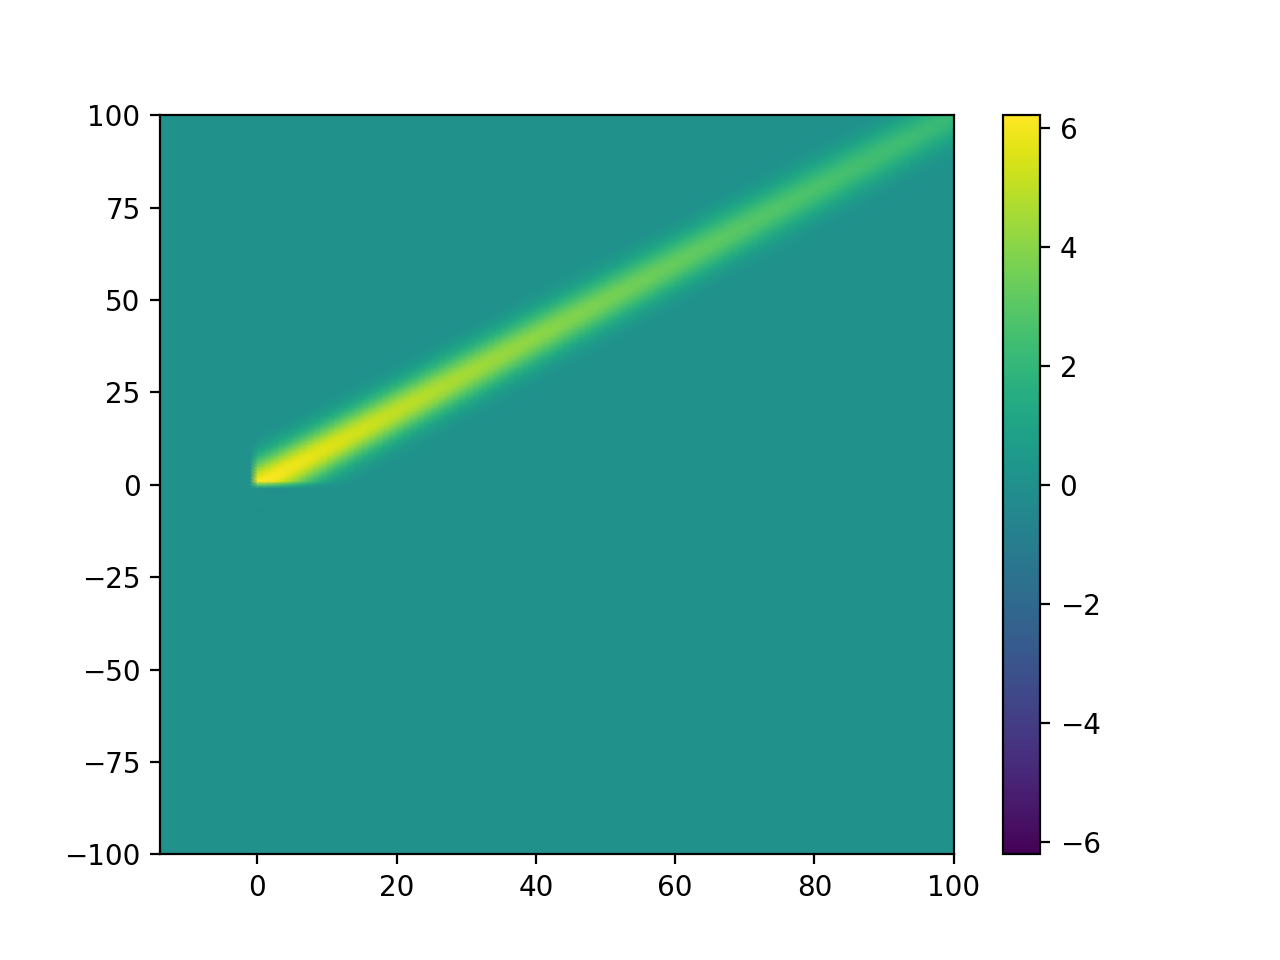

(<Figure size 640x480 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1818187860>)

In [25]:
# to get the data as a function of both tau and t (t being the ring-down of the photon echo signal), use
t, full_sig_tau_t = ft(tpe.w,full_signal,axis=1)
blur_sigma = 1/0.2 # I believe this is the value you use in your text document

# In the impulsive case all we need to do is this! (Note for finite pulses we will need to do some kind of
# averaging, as you have done in your uploaded code)
full_sig_tau_t = full_sig_tau_t * np.exp(-(t[np.newaxis,:]-tau[:,np.newaxis])**2/(2*blur_sigma**2))

ufss.signals.plot2D(tau,t,full_sig_tau_t,part='real',colormap='viridis')

### Finite pulses

In [26]:
#tpe is short for two-pulse echo
tpe = ufss.DensityMatrices(os.path.join(folder,'open/uf2'),detection_type='complex_polarization',conserve_memory=False)

# defining the impulsive pulses in the RWA
c = 1 # center frequency ofthe laser pulse
sigma1 = 1
sigma2 = 1 #can be different
Delta = 10
M = 21
t1 = np.linspace(-Delta/2,Delta/2,num=M) * sigma1

pulse1 = ufss.gaussian(t1,sigma1) # can be anything you want, I am just using a built-in Gaussian

t2 = np.linspace(-Delta/2,Delta/2,num=M) * sigma2 # can be different than t1 (different number of points, etc.)

pulse2 = ufss.gaussian(t2,sigma2) # can be anything you want, and does not have to be the same as pulse1

lo = np.array([1]) # local oscillator amplitude is 1
lo_t = np.array([0]) # impulsive limit, nonzero at a single time point

tpe.set_efields([t1,t2,t2],[pulse1,pulse2,pulse2],[c,c,c],pmc) #use same pmc as previous

#tpe.set_efields([t1,t2,lo_t],[pulse1,pulse2,lo],[c,c,c],pmc)

tpe.set_polarization_sequence(pulse_polarizations)


tpe.maximum_manifold = 1 # This tells ufss not to try to calculate something like excited-state absorption

gamma = 0.2
dt = 1
tpe.gamma_res = 20 # default value for this is 6.91
tpe.set_t(gamma,dt=dt)

tau = tpe.t.copy()[tpe.t > -15]
tpe.set_pulse_delays([tau])

/Users/prose/ufss/ufss/UF2/UF2_open_core.py:622: UserWarning: Could not automatically determine the initial thermal state. User must specify the initial condition, rho^(0), manually
  warnings.warn('Could not automatically determine the initial thermal state. User must specify the initial condition, rho^(0), manually')


In [27]:
## uncomment if previous cell warns "Could not automatically determine the initial thermal state. User must specify the initial condition, rho^(0), manually"
## This cell creates a thermal distribution of populations to initialize
## rho0 can be anything you want it to be (must have the correct shape, in this case 3x3 matrix)
populations = np.exp(-eigenvalues/kT)
populations = populations/populations.sum()
rho0 = np.diag(populations)

tpe.set_rho0_manual(rho0)

<IPython.core.display.Javascript object>


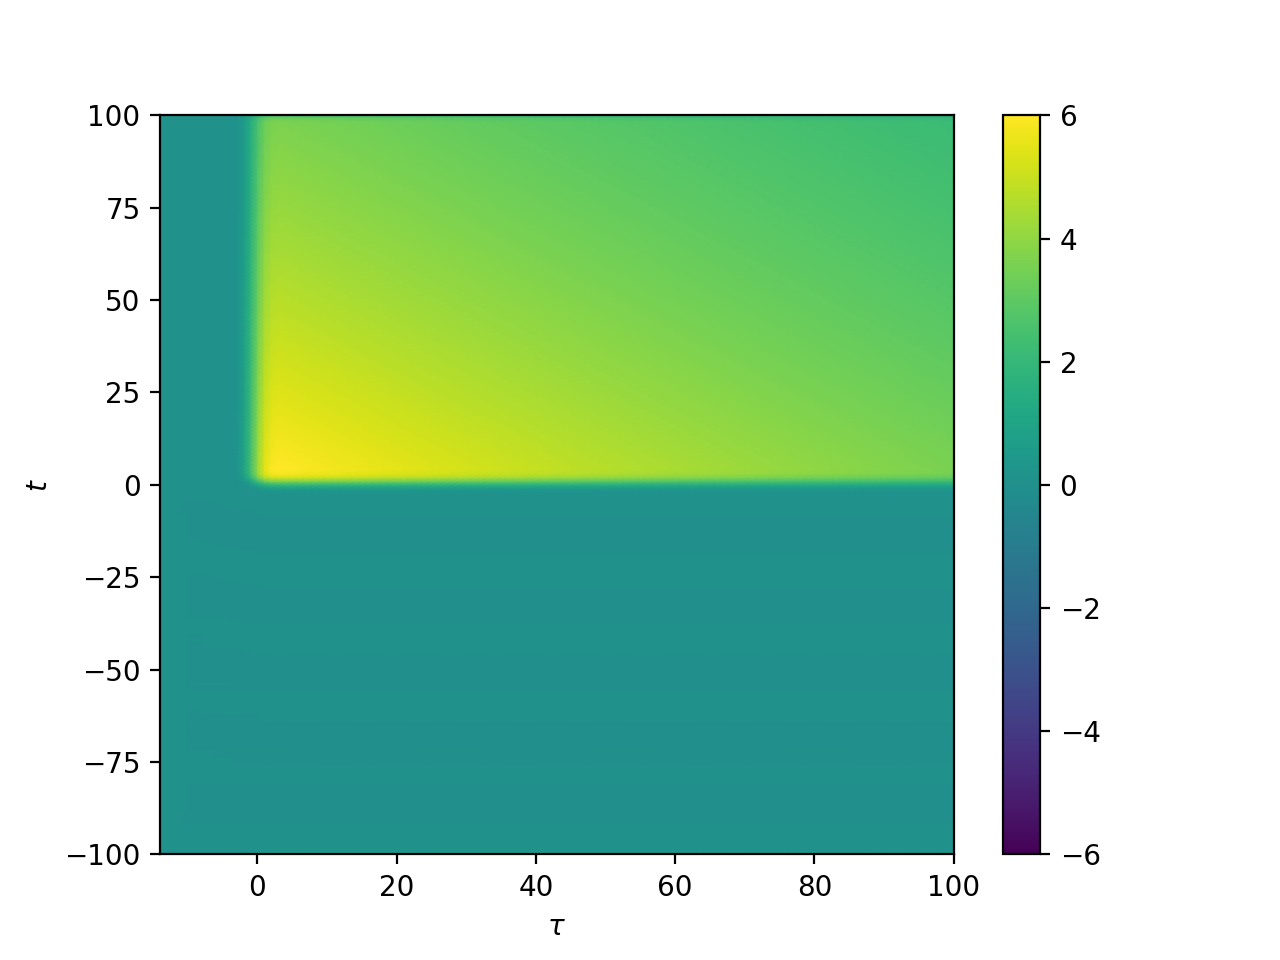

Text(0, 0.5, '$t$')

In [28]:
full_signal = tpe.calculate_signal_all_delays()

t, full_sig_tau_t = ft(tpe.w,full_signal,axis=1)

# unfortunately have to use recalculate many times to get inhomogeneous broadening

# without broadening:

ufss.signals.plot2D(tau,t,full_sig_tau_t,part='real',colormap='viridis')
plt.xlabel(r'$\tau$')
plt.ylabel('$t$')

### $tau = t$

The setup is nearly identical, except that we will call detection_type = 'integrated_polarization', and we will not set pulse delays.  We will handle the pulse arrival times manually

In [29]:
#tpe is short for two-pulse echo
tpe = ufss.DensityMatrices(os.path.join(folder,'open/uf2'),detection_type='integrated_polarization',conserve_memory=False)

# defining the impulsive pulses in the RWA
c = 1 # center frequency ofthe laser pulse
sigma1 = 1
sigma2 = 1 #can be different
Delta = 10
M = 21
t1 = np.linspace(-Delta/2,Delta/2,num=M) * sigma1

pulse1 = ufss.gaussian(t1,sigma1) # can be anything you want, I am just using a built-in Gaussian

t2 = np.linspace(-Delta/2,Delta/2,num=M) * sigma2 # can be different than t1 (different number of points, etc.)

pulse2 = ufss.gaussian(t2,sigma2) # can be anything you want, and does not have to be the same as pulse1

lo = ufss.gaussian(t1,sigma1) # currently doesn't support an impulsive local oscillator
lo_t = t1 # impulsive limit, nonzero at a single time point

tpe.set_efields([t1,t2,t2],[pulse1,pulse2,pulse2],[c,c,c],pmc) #use same pmc as previous

pulse_polarizations = ['r','r','r']

tpe.set_polarization_sequence(pulse_polarizations)


tpe.maximum_manifold = 1 # This tells ufss not to try to calculate something like excited-state absorption

gamma = 0.2
dt = 1
tpe.gamma_res = 20 # default value for this is 6.91
tpe.set_t(gamma,dt=dt)

tau = tpe.t.copy()[tpe.t > -15]

In [30]:
## uncomment if previous cell warns "Could not automatically determine the initial thermal state. User must specify the initial condition, rho^(0), manually"
## This cell creates a thermal distribution of populations to initialize
## rho0 can be anything you want it to be (must have the correct shape, in this case 3x3 matrix)
populations = np.exp(-eigenvalues/kT)
populations = populations/populations.sum()
rho0 = np.diag(populations)

tpe.set_rho0_manual(rho0)

The following part is new!

In [31]:
signal = np.zeros(tau.size,dtype='complex')
tpe.return_complex_signal = True #This is a flag to get the full complex signal
for i in range(tau.size):
    pulse_delays = [0,tau[i],2*tau[i]]
    signal[i] = tpe.calculate_signal(pulse_delays)

Note that the following plot is off from the above 2D color plot by a factor of $2\pi$.  This has to do with the difference between the way ufss has defined integrated and frequency-detected signals.  I'll fix this eventually

<IPython.core.display.Javascript object>


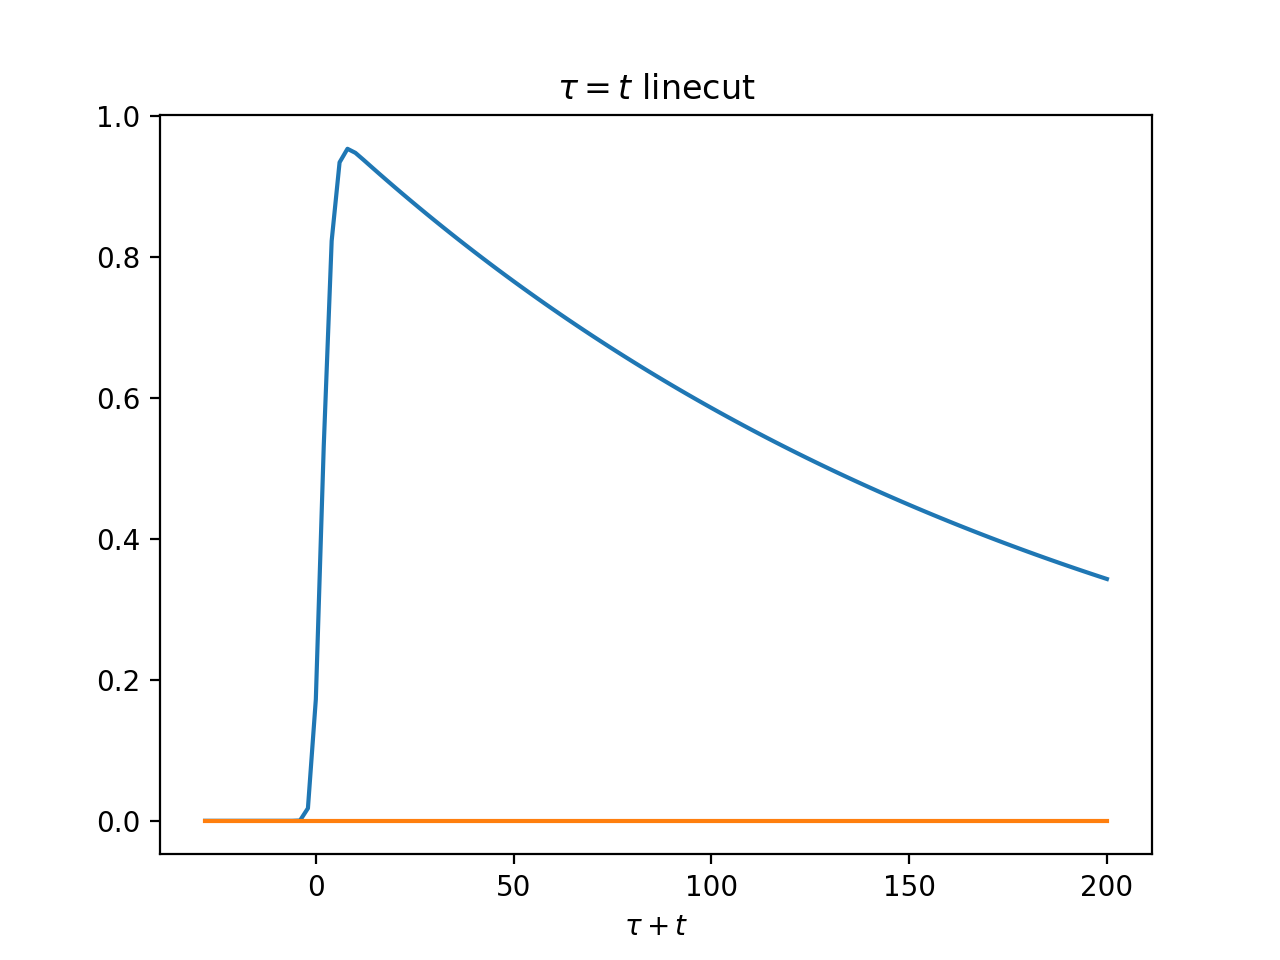

Text(0.5, 1.0, '$\\tau=t$ linecut')

In [32]:
plt.figure()
plt.plot(tau*2,np.real(signal))
plt.plot(tau*2,np.imag(signal))
plt.xlabel(r'$\tau+t$')
plt.title(r'$\tau=t$ linecut')

### Calculations with c = 0 ("Lab-frame" as opposed to rotating frame)

In [33]:
#tpe is short for two-pulse echo
tpe = ufss.DensityMatrices(os.path.join(folder,'open/uf2'),detection_type='complex_polarization',conserve_memory=False)

# defining the impulsive pulses in the RWA
c_rf = 0 # rotating-frame center
c_lf = 1.3 # pulse center frequency as measured in "lab-frame"
sigma1 = 1
sigma2 = 1 #can be different
Delta = 10
M = 41
t1 = np.linspace(-Delta/2,Delta/2,num=M) * sigma1

pulse1 = ufss.gaussian(t1,sigma1) * np.exp(-1j*c_lf*t1) # can be anything you want, I am just using a built-in Gaussian

t2 = np.linspace(-Delta/2,Delta/2,num=M) * sigma2 # can be different than t1 (different number of points, etc.)

pulse2 = ufss.gaussian(t2,sigma2) * np.exp(-1j*c_lf*t1) # can be anything you want, and does not have to be the same as pulse1

## could use the following instead if desired
#lo = np.array([1]) # local oscillator amplitude is 1
#lo_t = np.array([0]) # impulsive limit, nonzero at a single time point
#tpe.set_efields([t1,t2,lo_t],[pulse1,pulse2,lo],[c_rf,c_rf,c_rf],pmc)

tpe.set_efields([t1,t2,t2],[pulse1,pulse2,pulse2],[c_rf,c_rf,c_rf],pmc) #use same pmc as previous

tpe.set_polarization_sequence(pulse_polarizations)


tpe.maximum_manifold = 1 # This tells ufss not to try to calculate something like excited-state absorption

gamma = 0.2
dt = 1
tpe.gamma_res = 20 # default value for this is 6.91
tpe.set_t(gamma,dt=dt)

tau = tpe.t.copy()[tpe.t > -15]
tpe.set_pulse_delays([tau])

/Users/prose/ufss/ufss/UF2/UF2_open_core.py:622: UserWarning: Could not automatically determine the initial thermal state. User must specify the initial condition, rho^(0), manually
  warnings.warn('Could not automatically determine the initial thermal state. User must specify the initial condition, rho^(0), manually')


In [34]:
## uncomment if previous cell warns "Could not automatically determine the initial thermal state. User must specify the initial condition, rho^(0), manually"
## This cell creates a thermal distribution of populations to initialize
## rho0 can be anything you want it to be (must have the correct shape, in this case 3x3 matrix)
populations = np.exp(-eigenvalues/kT)
populations = populations/populations.sum()
rho0 = np.diag(populations)

tpe.set_rho0_manual(rho0)

<IPython.core.display.Javascript object>


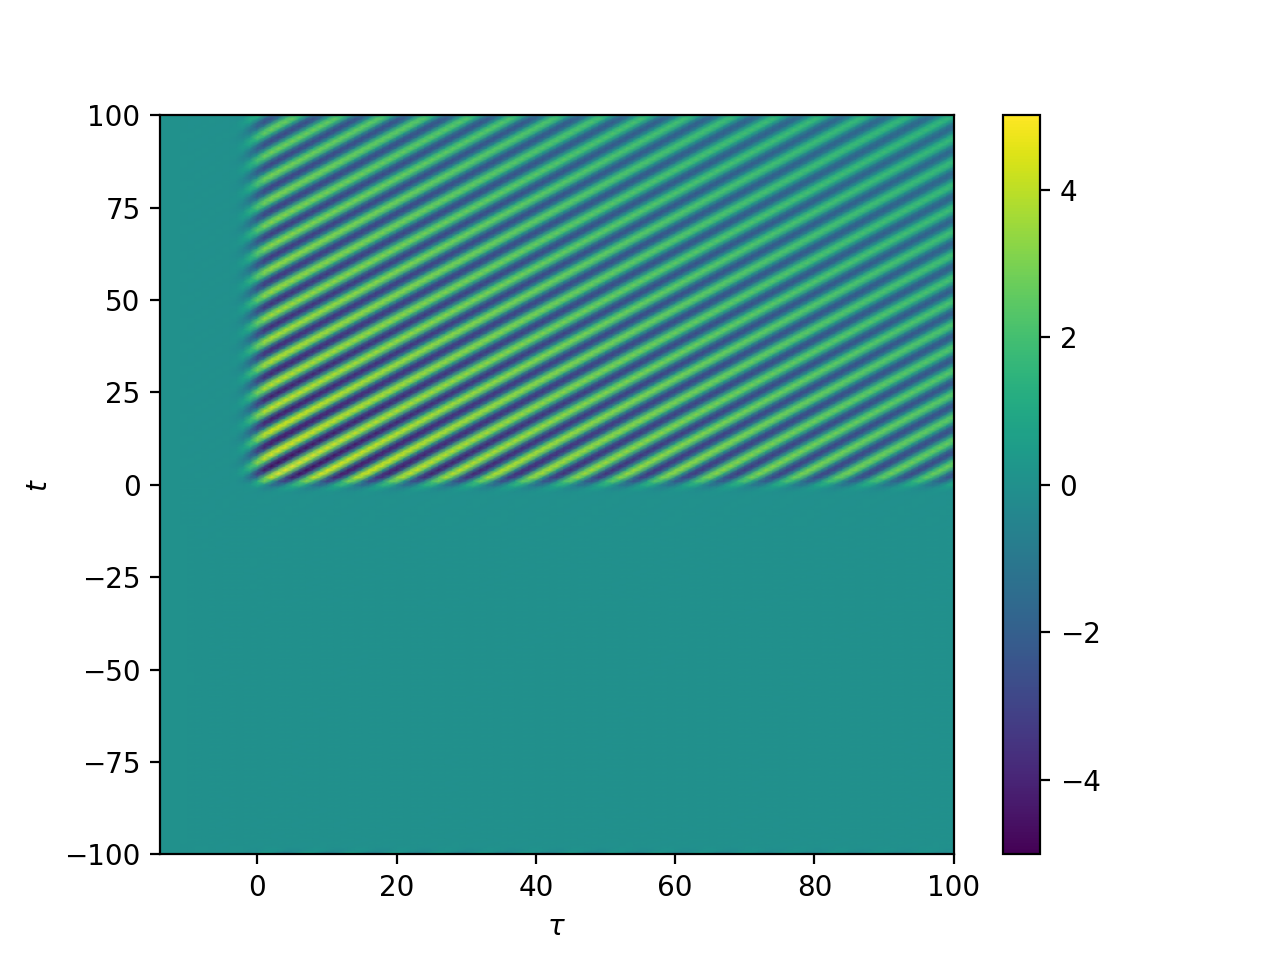

Text(0, 0.5, '$t$')

In [35]:
full_signal = tpe.calculate_signal_all_delays()

t, full_sig_tau_t = ft(tpe.w,full_signal,axis=1)

# unfortunately have to use recalculate many times to get inhomogeneous broadening

# without broadening:

ufss.signals.plot2D(tau,t,full_sig_tau_t,part='real',colormap='viridis')
plt.xlabel(r'$\tau$')
plt.ylabel('$t$')

### 5th-order contribution to the 2 pulse photon echo

the only change will be in the definition of the phase-matching condition, pmc

In [39]:
# both of the following new phase-matching conditions are fifth-order contributions (must be calculated separately)
pmc = [(1,2),(2,0)]
# pmc = [(0,1),(3,1)]

#tpe is short for two-pulse echo
tpe_5o = ufss.DensityMatrices(os.path.join(folder,'open/uf2'),detection_type='complex_polarization',conserve_memory=False)

# defining the impulsive pulses in the RWA
c_rf = 0 # rotating-frame center
c_lf = 1.3 # pulse center frequency as measured in "lab-frame"
sigma1 = 1
sigma2 = 1 #can be different
Delta = 10
M = 41
t1 = np.linspace(-Delta/2,Delta/2,num=M) * sigma1

# this is where an amplitude factor could start to be very important/meaningful!

pulse1 = ufss.gaussian(t1,sigma1) * np.exp(-1j*c_lf*t1) # can be anything you want, I am just using a built-in Gaussian

t2 = np.linspace(-Delta/2,Delta/2,num=M) * sigma2 # can be different than t1 (different number of points, etc.)

pulse2 = ufss.gaussian(t2,sigma2) * np.exp(-1j*c_lf*t1) # can be anything you want, and does not have to be the same as pulse1

## could use the following instead if desired
#lo = np.array([1]) # local oscillator amplitude is 1
#lo_t = np.array([0]) # impulsive limit, nonzero at a single time point
#tpe.set_efields([t1,t2,lo_t],[pulse1,pulse2,lo],[c_rf,c_rf,c_rf],pmc)

tpe.set_efields([t1,t2,t2],[pulse1,pulse2,pulse2],[c_rf,c_rf,c_rf],pmc) #use same pmc as previous

tpe.set_polarization_sequence(pulse_polarizations)


tpe.maximum_manifold = 1 # This tells ufss not to try to calculate something like excited-state absorption

gamma = 0.2
dt = 1
tpe.gamma_res = 20 # default value for this is 6.91
tpe.set_t(gamma,dt=dt)

tau = tpe.t.copy()[tpe.t > -15]
tpe.set_pulse_delays([tau])

In [40]:
## uncomment if previous cell warns "Could not automatically determine the initial thermal state. User must specify the initial condition, rho^(0), manually"
## This cell creates a thermal distribution of populations to initialize
## rho0 can be anything you want it to be (must have the correct shape, in this case 3x3 matrix)
populations = np.exp(-eigenvalues/kT)
populations = populations/populations.sum()
rho0 = np.diag(populations)

tpe.set_rho0_manual(rho0)

<IPython.core.display.Javascript object>


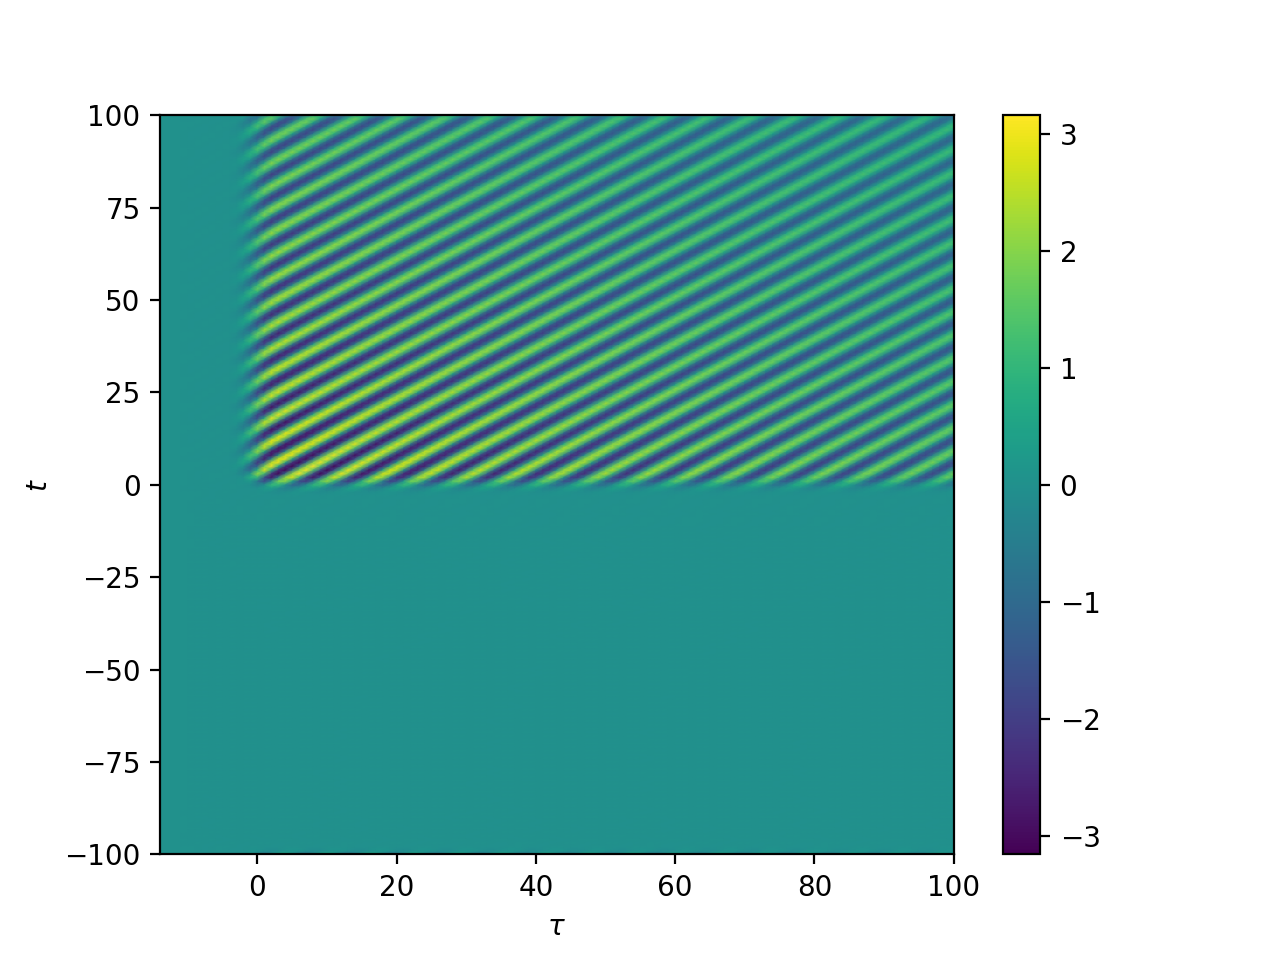

Text(0, 0.5, '$t$')

In [41]:
full_signal = tpe.calculate_signal_all_delays()

t, full_sig_tau_t = ft(tpe.w,full_signal,axis=1)

# unfortunately have to use recalculate many times to get inhomogeneous broadening

# without broadening:

ufss.signals.plot2D(tau,t,full_sig_tau_t,part='real',colormap='viridis')
plt.xlabel(r'$\tau$')
plt.ylabel('$t$')